# Draft Model

In [135]:
from bs4 import BeautifulSoup as BS
import pandas as pd
import numpy as np
import requests

In [136]:
ADP_URL = "https://www.fantasypros.com/nfl/adp/ppr-overall.php"

In [137]:
def make_adp_df():
    res = requests.get(ADP_URL)
    if res.ok:
        soup = BS(res.content, 'html.parser')
        table = soup.find('table', {'id':'data'})
        df = pd.read_html(str(table))[0]
        print('Output after reading the html:\n\n',df.head(),'\n')
        df = df[['Player Team (Bye)','POS','AVG']]
        print('Output after filtering:\n\n',df.head(),'\n')
        df['PLAYER'] = df['Player Team (Bye)'].apply(lambda x:' '.join(x.split()[:-2]))
        df['POS'] = df['POS'].apply(lambda x:x[:2])
        
        df = df[['PLAYER','POS','AVG']].sort_values(by='AVG')
        
        print('Final output:\n\n', df.head())
        
        return df
    
    else:
        print("Didn't work, try again")

In [138]:
df = make_adp_df()

Output after reading the html:

    Rank             Player Team (Bye)  POS  ESPN  MFL  RTSports  Fantrax  AVG
0     1  Christian McCaffrey CAR (13)  RB1   1.0  NaN       1.0      1.0  1.0
1     2       Saquon Barkley NYG (11)  RB2   2.0  NaN       2.0      2.0  2.0
2     3      Ezekiel Elliott DAL (10)  RB3   3.0  NaN       3.0      3.0  3.0
3     4           Dalvin Cook MIN (7)  RB4   4.0  NaN       4.0      6.0  4.7
4     5           Alvin Kamara NO (6)  RB5   5.0  NaN       5.0      5.0  5.0 

Output after filtering:

               Player Team (Bye)  POS  AVG
0  Christian McCaffrey CAR (13)  RB1  1.0
1       Saquon Barkley NYG (11)  RB2  2.0
2      Ezekiel Elliott DAL (10)  RB3  3.0
3           Dalvin Cook MIN (7)  RB4  4.7
4           Alvin Kamara NO (6)  RB5  5.0 

Final output:

                 PLAYER POS  AVG
0  Christian McCaffrey  RB  1.0
1       Saquon Barkley  RB  2.0
2      Ezekiel Elliott  RB  3.0
3          Dalvin Cook  RB  4.7
4         Alvin Kamara  RB  5.0


In [139]:
df.head()

,PLAYER,POS,AVG
0,Christian McCaffrey,RB,1.0
1,Saquon Barkley,RB,2.0
2,Ezekiel Elliott,RB,3.0
3,Dalvin Cook,RB,4.7
4,Alvin Kamara,RB,5.0


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594 entries, 0 to 593
Data columns (total 3 columns):
PLAYER    594 non-null object
POS       594 non-null object
AVG       594 non-null float64
dtypes: float64(1), object(2)
memory usage: 18.6+ KB


In [141]:
replacement_players = {
    'RB':None,
    'WR':None,
    'TE':None,
    'QB':None
}

In [142]:
replacement_players

{'RB': None, 'WR': None, 'TE': None, 'QB': None}

In [143]:
# look at the top 100 picks in our df and get the last RB, WR, QB, and TE
# and store them in our dict

for _, row in df[:100].iterrows():
    position = row['POS']
    player = row['PLAYER']
    replacement_players[position] = player
    
replacement_players

{'RB': 'Matt Breida',
 'WR': 'Diontae Johnson',
 'TE': 'Jared Cook',
 'QB': 'Carson Wentz'}

Get projected player scores

In [144]:
BASE_URL = 'https://www.fantasypros.com/nfl/projections/{position}.php?week=draft'

def make_projection_df():
    
    final_df = pd.DataFrame()
    
    for position in ['rb', 'qb', 'te', 'wr']:
        
        res = requests.get(BASE_URL.format(position=position))
        if res.ok:
            soup = BS(res.content, 'html.parser')
            table = soup.find('table', {'id': 'data'})
            df = pd.read_html(str(table))[0]
            
            df.columns = df.columns.droplevel(level=0)
            df['PLAYER'] = df['Player'].apply(lambda x: ' '.join(x.split()[:-1]))
            if 'REC' in df.columns:
                df['FPTS'] = df['FPTS'] + df['REC']
                
            df['POS'] = position.upper()
            
            df = df[['PLAYER', 'POS', 'FPTS']]
            final_df = pd.concat([final_df, df])
            
        else:
            print("Didn't work, try again")
            return
    
    final_df = final_df.sort_values(by='FPTS', ascending=False)
    
    return final_df

In [145]:
df = make_projection_df()
df.head()

,PLAYER,POS,FPTS
0,Christian McCaffrey,RB,375.0
0,Lamar Jackson,QB,361.0
1,Patrick Mahomes,QB,344.9
0,Michael Thomas,WR,337.8
2,Dak Prescott,QB,318.6


Calculate replacement values

In [146]:
replacement_values = {
    'RB':None,
    'WR':None,
    'TE':None,
    'QB':None
}

replacement_values

{'RB': None, 'WR': None, 'TE': None, 'QB': None}

In [147]:
for position, player in replacement_players.items():
    if position in ['QB','TE', 'WR', 'RB']:
        replacement_values[position] = df.loc[df['PLAYER'] == player].values[0,-1]
        
replacement_values

{'RB': 138.5, 'WR': 185.1, 'TE': 151.10000000000002, 'QB': 274.5}

In [148]:
df['VOR'] = df.apply(
    lambda row: row['FPTS'] - replacement_values.get(row['POS']), 
    axis=1
)
df.head()

,PLAYER,POS,FPTS,VOR
0,Christian McCaffrey,RB,375.0,236.5
0,Lamar Jackson,QB,361.0,86.5
1,Patrick Mahomes,QB,344.9,70.4
0,Michael Thomas,WR,337.8,152.7
2,Dak Prescott,QB,318.6,44.1


In [149]:
df = df.sort_values(by='VOR', ascending=False)
df['VALUERANK'] = df['VOR'].rank(ascending=False)
df.head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK
0,Christian McCaffrey,RB,375.0,236.5,1.0
1,Saquon Barkley,RB,310.9,172.4,2.0
2,Ezekiel Elliott,RB,303.6,165.1,3.0
5,Alvin Kamara,RB,298.4,159.9,4.0
0,Michael Thomas,WR,337.8,152.7,5.0
4,Dalvin Cook,RB,289.9,151.4,6.0
3,Derrick Henry,RB,261.9,123.4,7.0
1,Davante Adams,WR,302.8,117.7,8.0
6,Clyde Edwards-Helaire,RB,254.8,116.3,9.0
13,Austin Ekeler,RB,252.9,114.4,10.0


In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

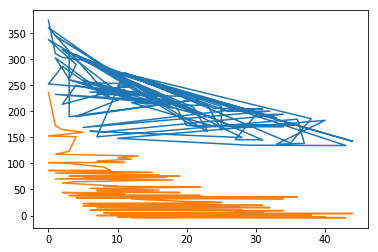

In [151]:
df.FPTS[:100].plot()
df.VOR[:100].plot()

In [152]:
# fig = plt.figure(figsize=(10,8))

# sns.lineplot(x='VALUERANK', y='VOR', data=df[df['POS'] == 'RB'])

# plt.show()

In [153]:
positions = list(set(df.POS.values))
positions

['QB', 'WR', 'TE', 'RB']

In [154]:
# for p in positions:
#     sns.lineplot(x='VALUERANK', y='VOR', data=df[df['POS'] == p])
#     plt.title(p)
#     plt.show()

# Avg Draft Pick

In [155]:
adp_df = make_adp_df()
adp_df.head()

Output after reading the html:

    Rank             Player Team (Bye)  POS  ESPN  MFL  RTSports  Fantrax  AVG
0     1  Christian McCaffrey CAR (13)  RB1   1.0  NaN       1.0      1.0  1.0
1     2       Saquon Barkley NYG (11)  RB2   2.0  NaN       2.0      2.0  2.0
2     3      Ezekiel Elliott DAL (10)  RB3   3.0  NaN       3.0      3.0  3.0
3     4           Dalvin Cook MIN (7)  RB4   4.0  NaN       4.0      6.0  4.7
4     5           Alvin Kamara NO (6)  RB5   5.0  NaN       5.0      5.0  5.0 

Output after filtering:

               Player Team (Bye)  POS  AVG
0  Christian McCaffrey CAR (13)  RB1  1.0
1       Saquon Barkley NYG (11)  RB2  2.0
2      Ezekiel Elliott DAL (10)  RB3  3.0
3           Dalvin Cook MIN (7)  RB4  4.7
4           Alvin Kamara NO (6)  RB5  5.0 

Final output:

                 PLAYER POS  AVG
0  Christian McCaffrey  RB  1.0
1       Saquon Barkley  RB  2.0
2      Ezekiel Elliott  RB  3.0
3          Dalvin Cook  RB  4.7
4         Alvin Kamara  RB  5.0


,PLAYER,POS,AVG
0,Christian McCaffrey,RB,1.0
1,Saquon Barkley,RB,2.0
2,Ezekiel Elliott,RB,3.0
3,Dalvin Cook,RB,4.7
4,Alvin Kamara,RB,5.0


In [156]:
adp_df['ADPRANK'] = adp_df['AVG'].rank(method='first')

adp_df.head()

,PLAYER,POS,AVG,ADPRANK
0,Christian McCaffrey,RB,1.0,1.0
1,Saquon Barkley,RB,2.0,2.0
2,Ezekiel Elliott,RB,3.0,3.0
3,Dalvin Cook,RB,4.7,4.0
4,Alvin Kamara,RB,5.0,5.0


Merge dataframes

In [157]:
df = df.merge(adp_df, how='left', on=['PLAYER', 'POS'])

df.head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK
0,Christian McCaffrey,RB,375.0,236.5,1.0,1.0,1.0
1,Saquon Barkley,RB,310.9,172.4,2.0,2.0,2.0
2,Ezekiel Elliott,RB,303.6,165.1,3.0,3.0,3.0
3,Alvin Kamara,RB,298.4,159.9,4.0,5.0,5.0
4,Michael Thomas,WR,337.8,152.7,5.0,5.3,6.0


In [158]:
df.head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK
0,Christian McCaffrey,RB,375.0,236.5,1.0,1.0,1.0
1,Saquon Barkley,RB,310.9,172.4,2.0,2.0,2.0
2,Ezekiel Elliott,RB,303.6,165.1,3.0,3.0,3.0
3,Alvin Kamara,RB,298.4,159.9,4.0,5.0,5.0
4,Michael Thomas,WR,337.8,152.7,5.0,5.3,6.0
5,Dalvin Cook,RB,289.9,151.4,6.0,4.7,4.0
6,Derrick Henry,RB,261.9,123.4,7.0,7.3,7.0
7,Davante Adams,WR,302.8,117.7,8.0,11.0,8.0
8,Clyde Edwards-Helaire,RB,254.8,116.3,9.0,16.0,17.0
9,Austin Ekeler,RB,252.9,114.4,10.0,15.0,15.0


In [159]:
df['SLEEPERSCORE'] = df['ADPRANK'] - df['VALUERANK']

df.head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE
0,Christian McCaffrey,RB,375.0,236.5,1.0,1.0,1.0,0.0
1,Saquon Barkley,RB,310.9,172.4,2.0,2.0,2.0,0.0
2,Ezekiel Elliott,RB,303.6,165.1,3.0,3.0,3.0,0.0
3,Alvin Kamara,RB,298.4,159.9,4.0,5.0,5.0,1.0
4,Michael Thomas,WR,337.8,152.7,5.0,5.3,6.0,1.0


# Sleeper Score 

In [160]:
df.loc[df['AVG'] < 160].sort_values(by='SLEEPERSCORE', ascending=False).head(20)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE
33,Antonio Gibson,RB,193.0,54.5,34.0,118.3,117.0,83.0
50,Tarik Cohen,RB,173.8,35.3,51.0,86.7,84.0,33.0
114,Ryan Tannehill,QB,258.3,-16.2,115.0,150.7,147.0,32.0
123,Jonnu Smith,TE,130.1,-21.0,124.0,158.3,156.0,32.0
115,Dallas Goedert,TE,134.7,-16.4,116.0,151.0,148.0,32.0
100,Mike Gesicki,TE,146.0,-5.1,101.0,131.3,130.0,29.0
98,Duke Johnson,RB,134.4,-4.1,99.0,130.3,128.0,29.0
109,Jared Goff,QB,260.7,-13.8,110.0,140.3,137.0,27.0
62,Josh Allen,QB,297.5,23.0,63.0,89.7,88.0,25.0
55,James White,RB,170.8,32.3,56.5,84.3,81.0,24.5


In [161]:
df.loc[df['AVG'] < 160].sort_values(by='SLEEPERSCORE', ascending=True).head(20)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE
189,Mecole Hardman,WR,123.4,-61.7,190.0,139.0,134.0,-56.0
163,Alexander Mattison,RB,94.5,-44.0,164.0,127.7,124.0,-40.0
116,Deebo Samuel,WR,168.3,-16.8,117.0,83.3,79.0,-38.0
154,Justin Jefferson,WR,143.9,-41.2,155.0,123.3,119.0,-36.0
148,Jerry Jeudy,WR,148.2,-36.9,149.0,115.0,113.0,-36.0
118,J.K. Dobbins,RB,119.2,-19.3,119.0,90.3,89.0,-30.0
133,Emmanuel Sanders,WR,158.9,-26.2,134.0,107.7,104.0,-30.0
107,Rob Gronkowski,TE,139.4,-11.7,108.0,81.3,78.0,-30.0
75,Leonard Fournette,RB,149.7,11.2,76.0,50.0,48.0,-28.0
149,Robby Anderson,WR,146.4,-38.7,150.0,127.7,123.0,-27.0


# Keeper Analysis

In [269]:
keepers_2020 = ['Davante Adams', 'George Kittle', 'D.J. Moore', 'D.J. Chark',
                'JuJu Smith-Schuster', 'Lamar Jackson', 'Kenyan Drake',
                'Raheem Mostert', 'Austin Ekeler', 'D.K. Metcalf',
                'Breshad Perriman', 'Adrian Peterson', 'Mark Andrews',
                'Terry McLaurin', 'A.J. Brown', 'James Conner', 'Tyreek Hill',
                'Alvin Kamara', 'Ronald Jones II', 'Tyler Boyd', 'Derrick Henry',
                'Chris Godwin', 'Joe Mixon', 'Aaron Jones', 'Ezekiel Elliott',
                'Nick Chubb', 'DeVante Parker', 'N/a ', 'Dalvin Cook',
                'Michael Thomas', 'Patrick Mahomes', 'N/a ','Marquise Brown',
                'Russell Wilson','Allen Robinson','Marlon Mack','Saquon Barkley',
                'Miles Sanders','David Johnson']

In [163]:
'Marquise Brown'
'Russel Wilson'
'Allen Robinson'
'Marlon Mack'
'Saquon Barkley'
'Miles Sanders'
'David Johnson'

'David Johnson'

In [164]:
keeper_df = pd.read_excel('Keeper_Master Document.xlsx',sheet_name=None)

In [165]:
# keeper_df.keys()

In [166]:
# keeper_df['Keeper History'].head()

In [167]:
# keeper_history = keeper_df['Keeper History']
# keeper_history.head()

In [168]:
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values

In [169]:
# keepers_2020

# Name Replacements

In [170]:
name_replacements = [('DJ Moore', 'D.J. Moore'),
 ('DJ Chark', 'D.J. Chark'),
 ('Juju Smith Schuster', 'JuJu Smith-Schuster'),
 ('JuJu Smith', 'JuJu Smith-Schuster'),
 ('DK Metcalf', 'D.K. Metcalf'),
 ('Brashad Perrimen', 'Breshad Perriman'),
 ('AJ Brown', 'A.J. Brown'),
 ('Ronald Jones', 'Ronald Jones II'),
 ('Ezekiel Elliot ', 'Ezekiel Elliott'),
 ('Ezekiel Elliot', 'Ezekiel Elliott'),
 ('Devante Parker ', 'DeVante Parker'),
 ('Devante Parker', 'DeVante Parker'),
 ('Saquon Barkely', 'Saquon Barkley'),
 ('Christian McAffrey', 'Christian McCaffrey'),
 ('Adam Thielan', 'Adam Thielen'),
 ('LeVeon Bell', "Le'Veon Bell"),
 ('Leornard Fournette', 'Leonard Fournette'),
 ('Mark Ingram', 'Mark Ingram II'),
 ('Mark Ingram ', 'Mark Ingram II'),
 ('TY Hilton', 'T.Y. Hilton'),
 ('Derius Guice', 'Derrius Guice'),
 ('AJ Green', 'A.J. Green'),
 ('Odell Beckham', 'Odell Beckham Jr.'),
 ('L McCoy', 'LeSean McCoy'),
 ('Alshon Jeffrey', 'Alshon Jeffery'),
 ('Marvin Jones Jr', 'Marvin Jones'),
 ('Darell Henderson', 'Darrell Henderson'),
 ('Russel Wilson', 'Russell Wilson'),
 ('A Miller', 'Anthony Miller'),
 ('DJ Metcalf', 'D.K. Metcalf'),
 ('Desean Jackson', 'DeSean Jackson'),
 ('Gio Bernard', 'Giovani Bernard'),
 ('Justice Mill', 'Justice Hill'),
 ('Kennan Ballage', 'Kalen Ballage'),
 ('Malcom Brown', 'Malcolm Brown'),
 ('Marques Valdez Scandling', 'Marquez Valdes-Scantling'),
 ('OJ Howard', 'O.J. Howard'),
 ('Philip Lindsay', 'Phillip Lindsay'),
 ('R Higgins', 'Rashard Higgins'),
 ('Rashad Penny', 'Rashaad Penny'),
 ('Tyreke Hill', 'Tyreek Hill'),
 ('TJ Hockenson', 'T.J. Hockenson')]

In [171]:
kickers = ['Greg Zuerlin',
 'Harrison Butker',
 'Justin Tucker',
 'Kai Fairbarn',
 'Mike Badgley',
 'Robbie Gould',
 'Stephen Gostowski',
 'Will Lutz',
 'Younghoe Koo',
 'Wil Lutz',
 'Austin Seibert']

In [172]:
defenses = ['Bears',
 'Rams',
 'Browns',
 'Eagles',
 'Jaguars',
 'Patriots',
 'Ravens',
 'Vikings',
 '49ers',
 'Broncos',
 'Chiefs',
 'Falcons',
 'Jets',
 'Pats']

In [173]:
unsigned_fa = ['Devonta Freeman',
 'Antonio Brown',
 'Derrius Guice',
 'Damien Williams',
 'Delanie Walker',
 'Geronimo Allison',
 'Josh Gordon',
 'Taylor Gabriel',
 'Tyrell Williams',
 'Adrian Peterson']

## Cleaning Keeper List

In [174]:
draft_19 = keeper_df['2019']

In [175]:
def check_names(check_list, correct_list):
    l = []
    for p in check_list:
        if p not in correct_list:
            l.append(p)
    return l

def find_name(name, source=df.PLAYER.values):
    for p in source:
        if name in p:
            print(p)
            
def name_replacer(wrong_name, correct_name, data=draft_19):
    data.replace(to_replace=wrong_name, value=correct_name, inplace=True)
    
def remove_fa_k_dst(main_list, fa, k, dst):
    main_list = np.setdiff1d(main_list, fa)
    main_list = np.setdiff1d(main_list, k)
    main_list = np.setdiff1d(main_list, dst)
    return main_list

In [176]:
keeper_replacements = [
    ('DJ Moore', 'D.J. Moore'), 
    ('DJ Chark', 'D.J. Chark'),
    ('Juju Smith Schuster', 'JuJu Smith-Schuster'),
    ('DK Metcalf', 'D.K. Metcalf'),
    ('Brashad Perrimen', 'Breshad Perriman'),
    ('AJ Brown', 'A.J. Brown'),
    ('Ronald Jones', 'Ronald Jones II'),
    ('Ezekiel Elliot ', 'Ezekiel Elliott'),
    ('Devante Parker ', 'DeVante Parker')
]

In [177]:
# for p in keeper_replacements:
#     keeper_history.replace(to_replace=p[0], value=p[1], inplace=True)

# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values
    
# keepers_2020

In [178]:
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [179]:
keeper_list = list(keepers_2020)

In [180]:
# keepers cleaned
keepers_2020 = np.array(keeper_list)
keepers_2020

array(['Davante Adams', 'George Kittle', 'D.J. Moore', 'D.J. Chark',
       'JuJu Smith-Schuster', 'Lamar Jackson', 'Kenyan Drake',
       'Raheem Mostert', 'Austin Ekeler', 'D.K. Metcalf',
       'Breshad Perriman', 'Adrian Peterson', 'Mark Andrews',
       'Terry McLaurin', 'A.J. Brown', 'James Conner', 'Tyreek Hill',
       'Alvin Kamara', 'Ronald Jones II', 'Tyler Boyd', 'Derrick Henry',
       'Chris Godwin', 'Joe Mixon', 'Aaron Jones', 'Ezekiel Elliott',
       'Nick Chubb', 'DeVante Parker', 'N/a ', 'Dalvin Cook',
       'Michael Thomas', 'Patrick Mahomes', 'N/a ', 'Marquise Brown',
       'Russel Wilson', 'Allen Robinson', 'Marlon Mack', 'Saquon Barkley',
       'Miles Sanders', 'David Johnson'], dtype='<U19')

# Last Year's Draft Picks

In [181]:
draft_19 = keeper_df['2019']

In [182]:
draft_19.columns[:8]

Index(['Tony', 'Mike', 'Joey', 'Vlad', 'Dave', 'Chris', 'Matt', 'Ben'], dtype='object')

In [183]:
draft_19.index[:18]

Index(['Round 1', 'Round 2', 'Round 3', 'Round 4', 'Round 5', 'Round 6',
       'Round 7', 'Round 8', 'Round 9', 'Round 10', 'Round 11', 'Round 12',
       'Round 13', 'Round 14', 'Round 15', 'Round 16', 'Round 17', 'Round 18'],
      dtype='object')

In [184]:
draft_19 = draft_19.iloc[:, :8]
draft_19

,Tony,Mike,Joey,Vlad,Dave,Chris,Matt,Ben
Round 1,Saquon Barkely,Ezekiel Elliot,Deshaun Watson,Julio Jones,Todd Gurley,Travis Kelce,Antonio Brown,Christian McAffrey
Round 2,Adam Thielan,Josh Jacobs,Amari Cooper,Chris Carson,Zach Ertz,Dalvin Cook,LeVeon Bell,Keenan Allen
Round 3,David Montgomery,Sony Michel,Leornard Fournette,Mike Williams,Mark Ingram,Melvin Gordon,Derrick Henry,Kenny Golladay
Round 4,Brandin Cooks,Kerryon Johnson,Stefon Diggs,Chris Godwin,DeAndre Hopkins,Julian Edelman,TY Hilton,Derius Guice
Round 5,Tevin Coleman,Mike Evans,Austin Ekeler,Evan Engram,Tyler Boyd,Calvin Ridley,AJ Green,Tyler Lockett
Round 6,Allen Robinson,Robert Woods,Tony Pollard,Devin Singletary,Christian Kirk,Odell Beckham,L McCoy,Miles Sanders
Round 7,Aaron Rodgers,Robby Anderson,Jarvis Landry,Baker Mayfield,Duke Johnson,Alshon Jeffrey,Courtland Sutton,Cam Newton
Round 8,Jordan Howard,Marvin Jones Jr,Sammy Watkins,Darell Henderson,Russel Wilson,Dede Westbrook,Kenyan Drake,Latavius Murray
Round 9,Matt Breida,Vance McDonald,James White,Larry Fitzgerald,Tarik Cohen,Greg Zuerlin,Emmanuel Sanders,Jared Cook
Round 10,Devonta Freeman,Curtis Samuel,Geronimo Allison,Rashad Penny,Justin Tucker,Mike Thomas,James Washington,Kyler Murray


In [185]:
all_players_19 = draft_19.values.flatten()

In [186]:
all_players_19

array(['Saquon Barkely', 'Ezekiel Elliot', 'Deshaun Watson',
       'Julio Jones', 'Todd Gurley', 'Travis Kelce', 'Antonio Brown',
       'Christian McAffrey', 'Adam Thielan', 'Josh Jacobs',
       'Amari Cooper', 'Chris Carson', 'Zach Ertz', 'Dalvin Cook',
       'LeVeon Bell', 'Keenan Allen', 'David Montgomery', 'Sony Michel',
       'Leornard Fournette', 'Mike Williams', 'Mark Ingram',
       'Melvin Gordon', 'Derrick Henry', 'Kenny Golladay',
       'Brandin Cooks', 'Kerryon Johnson', 'Stefon Diggs', 'Chris Godwin',
       'DeAndre Hopkins', 'Julian Edelman', 'TY Hilton', 'Derius Guice',
       'Tevin Coleman', 'Mike Evans', 'Austin Ekeler', 'Evan Engram',
       'Tyler Boyd', 'Calvin Ridley', 'AJ Green', 'Tyler Lockett',
       'Allen Robinson', 'Robert Woods', 'Tony Pollard',
       'Devin Singletary', 'Christian Kirk', 'Odell Beckham', 'L McCoy',
       'Miles Sanders', 'Aaron Rodgers', 'Robby Anderson',
       'Jarvis Landry', 'Baker Mayfield', 'Duke Johnson',
       'Alshon Je

In [187]:
names_to_fix = check_names(all_players_19, df.PLAYER.values)

In [188]:
len(names_to_fix)

137

In [189]:
# original_keepers = [p[0] for p in keeper_replacements]

# for p in original_keepers:
#     if p in names_to_fix:
#         print(p)

In [190]:
for p in name_replacements:
    draft_19.replace(to_replace=p[0], value=p[1], inplace=True)

all_players_19 = draft_19.values.flatten()
    
names_to_fix = check_names(all_players_19, df.PLAYER.values)
len(names_to_fix)

95

In [191]:
names_to_fix = remove_fa_k_dst(names_to_fix, unsigned_fa, kickers, defenses)
names_to_fix

array(['Donte Moncrief', 'Hakeem Butler', 'Kalen Ballage', 'Trey Edmunds',
       'nan'], dtype='<U17')

In [192]:
names_to_fix

array(['Donte Moncrief', 'Hakeem Butler', 'Kalen Ballage', 'Trey Edmunds',
       'nan'], dtype='<U17')

In [193]:
draft_19

,Tony,Mike,Joey,Vlad,Dave,Chris,Matt,Ben
Round 1,Saquon Barkley,Ezekiel Elliott,Deshaun Watson,Julio Jones,Todd Gurley,Travis Kelce,Antonio Brown,Christian McCaffrey
Round 2,Adam Thielen,Josh Jacobs,Amari Cooper,Chris Carson,Zach Ertz,Dalvin Cook,Le'Veon Bell,Keenan Allen
Round 3,David Montgomery,Sony Michel,Leonard Fournette,Mike Williams,Mark Ingram II,Melvin Gordon,Derrick Henry,Kenny Golladay
Round 4,Brandin Cooks,Kerryon Johnson,Stefon Diggs,Chris Godwin,DeAndre Hopkins,Julian Edelman,T.Y. Hilton,Derrius Guice
Round 5,Tevin Coleman,Mike Evans,Austin Ekeler,Evan Engram,Tyler Boyd,Calvin Ridley,A.J. Green,Tyler Lockett
Round 6,Allen Robinson,Robert Woods,Tony Pollard,Devin Singletary,Christian Kirk,Odell Beckham Jr.,LeSean McCoy,Miles Sanders
Round 7,Aaron Rodgers,Robby Anderson,Jarvis Landry,Baker Mayfield,Duke Johnson,Alshon Jeffery,Courtland Sutton,Cam Newton
Round 8,Jordan Howard,Marvin Jones,Sammy Watkins,Darrell Henderson,Russell Wilson,Dede Westbrook,Kenyan Drake,Latavius Murray
Round 9,Matt Breida,Vance McDonald,James White,Larry Fitzgerald,Tarik Cohen,Greg Zuerlin,Emmanuel Sanders,Jared Cook
Round 10,Devonta Freeman,Curtis Samuel,Geronimo Allison,Rashaad Penny,Justin Tucker,Mike Thomas,James Washington,Kyler Murray


# Keep Filtering

In [194]:
df.head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE
0,Christian McCaffrey,RB,375.0,236.5,1.0,1.0,1.0,0.0
1,Saquon Barkley,RB,310.9,172.4,2.0,2.0,2.0,0.0
2,Ezekiel Elliott,RB,303.6,165.1,3.0,3.0,3.0,0.0
3,Alvin Kamara,RB,298.4,159.9,4.0,5.0,5.0,1.0
4,Michael Thomas,WR,337.8,152.7,5.0,5.3,6.0,1.0


In [195]:
keepers_2020

array(['Davante Adams', 'George Kittle', 'D.J. Moore', 'D.J. Chark',
       'JuJu Smith-Schuster', 'Lamar Jackson', 'Kenyan Drake',
       'Raheem Mostert', 'Austin Ekeler', 'D.K. Metcalf',
       'Breshad Perriman', 'Adrian Peterson', 'Mark Andrews',
       'Terry McLaurin', 'A.J. Brown', 'James Conner', 'Tyreek Hill',
       'Alvin Kamara', 'Ronald Jones II', 'Tyler Boyd', 'Derrick Henry',
       'Chris Godwin', 'Joe Mixon', 'Aaron Jones', 'Ezekiel Elliott',
       'Nick Chubb', 'DeVante Parker', 'N/a ', 'Dalvin Cook',
       'Michael Thomas', 'Patrick Mahomes', 'N/a ', 'Marquise Brown',
       'Russel Wilson', 'Allen Robinson', 'Marlon Mack', 'Saquon Barkley',
       'Miles Sanders', 'David Johnson'], dtype='<U19')

In [196]:
df['KEEPER'] = df.PLAYER.isin(keepers_2020)
df.head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER
0,Christian McCaffrey,RB,375.0,236.5,1.0,1.0,1.0,0.0,False
1,Saquon Barkley,RB,310.9,172.4,2.0,2.0,2.0,0.0,True
2,Ezekiel Elliott,RB,303.6,165.1,3.0,3.0,3.0,0.0,True
3,Alvin Kamara,RB,298.4,159.9,4.0,5.0,5.0,1.0,True
4,Michael Thomas,WR,337.8,152.7,5.0,5.3,6.0,1.0,True


## Begin df_no_keep

In [197]:
df_no_keep = df[df["KEEPER"] == False].copy()
df_no_keep

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER
0,Christian McCaffrey,RB,375.0,236.5,1.0,1.0,1.0,0.0,False
8,Clyde Edwards-Helaire,RB,254.8,116.3,9.0,16.0,17.0,8.0,False
14,Travis Kelce,TE,252.7,101.6,15.0,18.0,20.0,5.0,False
15,Julio Jones,WR,286.4,101.3,16.0,15.7,16.0,0.0,False
16,Josh Jacobs,RB,231.5,93.0,17.0,13.7,10.0,-7.0,False
21,Todd Gurley,RB,216.5,78.0,22.0,31.0,29.0,7.0,False
22,Chris Carson,RB,214.1,75.6,24.0,32.0,31.0,7.0,False
24,Le'Veon Bell,RB,214.1,75.6,24.0,38.3,37.0,13.0,False
25,DeAndre Hopkins,WR,259.8,74.7,26.0,14.0,12.0,-14.0,False
28,Melvin Gordon,RB,206.9,68.4,29.0,41.3,40.0,11.0,False


## Add Keep Pick Eligibility

In [198]:
# keep_el = pd.read_excel('Keeper_Eligibility.xlsx', sheet_name=None)

In [199]:
# keep_el['penalty_keeps']

In [200]:
# keep_el['maintain_position']

In [201]:
# for p in name_replacements:
#     keep_el['penalty_keeps'].replace(to_replace=p[0], value=p[1], inplace=True)

In [202]:
# for p in name_replacements:
#     keep_el['maintain_position'].replace(to_replace=p[0], value=p[1], inplace=True)

In [203]:
# all_keeps = keep_el['maintain_position'].merge(keep_el['penalty_keeps'], on='PLAYER', how='outer')


In [204]:
# all_keeps['KEEPER'] = all_keeps.PLAYER.isin(keepers_2020)

In [205]:
# all_keeps = all_keeps[all_keeps['KEEPER'] == False]

In [206]:
# all_keeps

In [207]:
# merge1 = df_no_keep.merge(all_keeps,how='left', on='PLAYER')

In [208]:
# merge1

In [209]:
# merge1 = merge1.rename(columns={'KEEPER_y':'eligible'})

In [210]:
# merge2 = merge1.merge(keep_el['maintain_position'], how='inner', on='PLAYER')

In [211]:
pd.set_option('display.max_rows', None)

In [212]:
# merge2.drop(columns=['keep_eligibilty_x'], inplace=True)

In [213]:
# df_final = merge1.copy()

In [214]:
# df_final['VALUE_ROUND'] = (df_final['VALUERANK'] // 10) + 1 
# df_final

In [215]:
# df_final['keep_score'] = df_final['keep_eligibilty_x'] - df_final['VALUE_ROUND']
# df_final

# Final Keeper Analysis



In [216]:
# df_final.sort_values(by='SLEEPERSCORE', ascending=False)

In [217]:
# df_final.to_csv('position_analysis.csv')

# My Team

In [218]:
my_team = ['Saquon Barkley', 'Miles Sanders', 'David Johnson']

In [219]:
df_no_keep.head(30)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER
0,Christian McCaffrey,RB,375.0,236.5,1.0,1.0,1.0,0.0,False
8,Clyde Edwards-Helaire,RB,254.8,116.3,9.0,16.0,17.0,8.0,False
14,Travis Kelce,TE,252.7,101.6,15.0,18.0,20.0,5.0,False
15,Julio Jones,WR,286.4,101.3,16.0,15.7,16.0,0.0,False
16,Josh Jacobs,RB,231.5,93.0,17.0,13.7,10.0,-7.0,False
21,Todd Gurley,RB,216.5,78.0,22.0,31.0,29.0,7.0,False
22,Chris Carson,RB,214.1,75.6,24.0,32.0,31.0,7.0,False
24,Le'Veon Bell,RB,214.1,75.6,24.0,38.3,37.0,13.0,False
25,DeAndre Hopkins,WR,259.8,74.7,26.0,14.0,12.0,-14.0,False
28,Melvin Gordon,RB,206.9,68.4,29.0,41.3,40.0,11.0,False


In [220]:
test_df = df_no_keep.copy()

In [221]:
test_df['available'] = True

In [222]:
test_df.loc[test_df['PLAYER'] == 'Christian McCaffrey', ['available']] = True

In [223]:
def avail_updtr(name, df=test_df, status=False):
    if name in df.PLAYER.values:
        df.loc[df['PLAYER'] == name, ['available']] = status
    else:
        print('incorrect name, try again')

In [224]:
avail_updtr('Christian McCaffrey', status=True)

In [225]:
test_df.head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available
0,Christian McCaffrey,RB,375.0,236.5,1.0,1.0,1.0,0.0,False,True
8,Clyde Edwards-Helaire,RB,254.8,116.3,9.0,16.0,17.0,8.0,False,True
14,Travis Kelce,TE,252.7,101.6,15.0,18.0,20.0,5.0,False,True
15,Julio Jones,WR,286.4,101.3,16.0,15.7,16.0,0.0,False,True
16,Josh Jacobs,RB,231.5,93.0,17.0,13.7,10.0,-7.0,False,True


In [226]:
def best_avail(position=None, df=test_df, head_n=10):
    if position == None:
        df.sort_values(by="VALUERANK").head(head_n)
    elif position in ['RB','TE','WR','QB']:
        df[df['POS'] == position].sort_values(by="VALUERANK").head(head_n)
    else:
        print('incorrect postion value')

In [227]:
b = best_avail('RB')

In [228]:
b

In [229]:
test_df[test_df['POS'] == 'RB'].sort_values(by="VALUERANK").head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available
0,Christian McCaffrey,RB,375.0,236.5,1.0,1.0,1.0,0.0,False,True
8,Clyde Edwards-Helaire,RB,254.8,116.3,9.0,16.0,17.0,8.0,False,True
16,Josh Jacobs,RB,231.5,93.0,17.0,13.7,10.0,-7.0,False,True
21,Todd Gurley,RB,216.5,78.0,22.0,31.0,29.0,7.0,False,True
22,Chris Carson,RB,214.1,75.6,24.0,32.0,31.0,7.0,False,True


In [230]:
test_df.head(20)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available
0,Christian McCaffrey,RB,375.0,236.5,1.0,1.0,1.0,0.0,False,True
8,Clyde Edwards-Helaire,RB,254.8,116.3,9.0,16.0,17.0,8.0,False,True
14,Travis Kelce,TE,252.7,101.6,15.0,18.0,20.0,5.0,False,True
15,Julio Jones,WR,286.4,101.3,16.0,15.7,16.0,0.0,False,True
16,Josh Jacobs,RB,231.5,93.0,17.0,13.7,10.0,-7.0,False,True
21,Todd Gurley,RB,216.5,78.0,22.0,31.0,29.0,7.0,False,True
22,Chris Carson,RB,214.1,75.6,24.0,32.0,31.0,7.0,False,True
24,Le'Veon Bell,RB,214.1,75.6,24.0,38.3,37.0,13.0,False,True
25,DeAndre Hopkins,WR,259.8,74.7,26.0,14.0,12.0,-14.0,False,True
28,Melvin Gordon,RB,206.9,68.4,29.0,41.3,40.0,11.0,False,True


In [231]:
my_team

['Saquon Barkley', 'Miles Sanders', 'David Johnson']

In [232]:
team_roster = {
    'QB':None,
    'RB1':None,
    'RB2':None,
    'WR1':None,
    'WR2':None,
    'FLEX1':None,
    'FLEX2':None,
    'TE':None,
    'K':None,
    'DST':None,
    'Bench1':None,
    'Bench2':None,
    'Bench3':None,
    'Bench4':None,
    'Bench5':None,
    'Bench6':None,
    'Bench7':None,
    'Bench8':None,  
}

In [233]:
# determine player position
# top player in position = Pos1
# if RB or WR pos - second player in position = Pos2 
# all other players go to "yet to place pool"
# after players placed - top 2 WR/RB/TE become Flex1/Flex2
# finally all players are on bench

In [234]:
my_tm_df = df[df['PLAYER'].isin(my_team)]

In [235]:
my_tm_df

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER
1,Saquon Barkley,RB,310.9,172.4,2.0,2.0,2.0,0.0,True
10,Miles Sanders,RB,249.5,111.0,11.0,13.7,9.0,-2.0,True
26,David Johnson,RB,211.5,73.0,27.0,38.0,36.0,9.0,True


In [236]:
def make_roster(team_members, df=my_tm_df, roster=team_roster):
    #place_later = []
    #place RBs 
    rbs = df[df['POS'] == 'RB'].sort_values(by='FPTS', ascending=False)
   
    team_roster['RB1'] = (rbs.iloc[0,0], rbs.iloc[0,2])
    
    team_roster['RB2'] = (rbs.iloc[1,0], rbs.iloc[1,2])
    
#     place_later = rbs.iloc[2:,0].values
    
    #place WRs 
    wrs = df[df['POS'] == 'WR'].sort_values(by='FPTS', ascending=False)
   
    team_roster['WR1'] = (wrs.iloc[0,0], wrs.iloc[0,2])
    
    team_roster['WR2'] = (wrs.iloc[1,0], wrs.iloc[1,2])
    
#     place_later = place_later + (wrs.iloc[2:,0].values)
    
    #place QBs 
    qbs = df[df['POS'] == 'QB'].sort_values(by='FPTS', ascending=False)
   
    team_roster['QB'] = (qbs.iloc[0,0], qbs.iloc[0,2])
    
#     place_later.append(qbs.iloc[1:,0].values)
#     place_later = place_later + (qbs.iloc[1:,0].values)
    
    #place TEs 
    tes = df[df['POS'] == 'TE'].sort_values(by='FPTS', ascending=False)
   
    team_roster['TE'] = (tes.iloc[0,0], tes.iloc[0,2])
    
#     place_later.append(tes.iloc[1:,0].values)
#     place_later = place_later + (tes.iloc[1:,0].values)
    
    place_later = (rbs.iloc[2:,0].values)+(wrs.iloc[2:,0].values)+(qbs.iloc[1:,0].values)+(tes.iloc[1:,0].values)
    display(place_later)
    #place Flex
#     flexs = df[df['PLAYER'].isin(place_later)].sort_values(by='FPTS',
#                                                            ascending=False)
# #     eligible_pos = ['RB','WR','TE']
    
# #     flexs = flexs[flexs['POS'].isin(eligible_pos)]
    
#     team_roster['FLEX1'] = (flexs.iloc[0,0], flexs.iloc[0,2])
    
#     team_roster['FLEX2'] = (flexs.iloc[1,0], flexs.iloc[1,2])

In [237]:
my_tm_df.iloc[2:,0].values

array(['David Johnson'], dtype=object)

In [238]:
# make_roster(my_team)

In [239]:
team_roster

{'QB': None,
 'RB1': None,
 'RB2': None,
 'WR1': None,
 'WR2': None,
 'FLEX1': None,
 'FLEX2': None,
 'TE': None,
 'K': None,
 'DST': None,
 'Bench1': None,
 'Bench2': None,
 'Bench3': None,
 'Bench4': None,
 'Bench5': None,
 'Bench6': None,
 'Bench7': None,
 'Bench8': None}

In [240]:
test_df['val_rnd'] = (test_df['VALUERANK'] // 10) + 1 
test_df['adp_rnd'] = (test_df['ADPRANK'] // 10) + 1

# Work Area

In [241]:
keepers_2020

array(['Davante Adams', 'George Kittle', 'D.J. Moore', 'D.J. Chark',
       'JuJu Smith-Schuster', 'Lamar Jackson', 'Kenyan Drake',
       'Raheem Mostert', 'Austin Ekeler', 'D.K. Metcalf',
       'Breshad Perriman', 'Adrian Peterson', 'Mark Andrews',
       'Terry McLaurin', 'A.J. Brown', 'James Conner', 'Tyreek Hill',
       'Alvin Kamara', 'Ronald Jones II', 'Tyler Boyd', 'Derrick Henry',
       'Chris Godwin', 'Joe Mixon', 'Aaron Jones', 'Ezekiel Elliott',
       'Nick Chubb', 'DeVante Parker', 'N/a ', 'Dalvin Cook',
       'Michael Thomas', 'Patrick Mahomes', 'N/a ', 'Marquise Brown',
       'Russel Wilson', 'Allen Robinson', 'Marlon Mack', 'Saquon Barkley',
       'Miles Sanders', 'David Johnson'], dtype='<U19')

In [242]:
draft_df = test_df.copy()

In [243]:
draft_df.head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
0,Christian McCaffrey,RB,375.0,236.5,1.0,1.0,1.0,0.0,False,True,1.0,1.0
8,Clyde Edwards-Helaire,RB,254.8,116.3,9.0,16.0,17.0,8.0,False,True,1.0,2.0
14,Travis Kelce,TE,252.7,101.6,15.0,18.0,20.0,5.0,False,True,2.0,3.0
15,Julio Jones,WR,286.4,101.3,16.0,15.7,16.0,0.0,False,True,2.0,2.0
16,Josh Jacobs,RB,231.5,93.0,17.0,13.7,10.0,-7.0,False,True,2.0,2.0


## My Team

In [244]:
my_team

['Saquon Barkley', 'Miles Sanders', 'David Johnson']

### Find name and add to my team

In [1042]:
find_name('Gardner Minshew II')

Allen Lazard


In [1078]:
my_new_player = 'Gardner Minshew II'

In [1079]:
my_team.append(my_new_player)

In [1080]:
my_tm_df = df[df['PLAYER'].isin(my_team)]

In [1081]:
my_tm_df

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER
1,Saquon Barkley,RB,310.9,172.4,2.0,2.0,2.0,0.0,True
10,Miles Sanders,RB,249.5,111.0,11.0,13.7,9.0,-2.0,True
21,Todd Gurley,RB,216.5,78.0,22.0,31.0,29.0,7.0,False
26,David Johnson,RB,211.5,73.0,27.0,38.0,36.0,9.0,True
34,Cooper Kupp,WR,238.1,53.0,35.0,37.7,35.0,0.0,False
42,Dak Prescott,QB,318.6,44.1,43.0,54.0,52.0,9.0,False
44,Darren Waller,TE,189.8,38.7,45.0,55.7,53.0,8.0,False
62,Josh Allen,QB,297.5,23.0,63.0,89.7,88.0,25.0,False
88,Sterling Shepard,WR,185.9,0.8,89.0,102.7,98.0,9.0,False
98,Duke Johnson,RB,134.4,-4.1,99.0,130.3,128.0,29.0,False


In [1082]:
my_tm_df.POS.value_counts()

RB    5
WR    5
QB    3
TE    3
Name: POS, dtype: int64

In [1017]:
draft_df.head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
0,Christian McCaffrey,RB,375.0,236.5,1.0,1.0,1.0,0.0,False,False,1.0,1.0
8,Clyde Edwards-Helaire,RB,254.8,116.3,9.0,16.0,17.0,8.0,False,False,1.0,2.0
14,Travis Kelce,TE,252.7,101.6,15.0,18.0,20.0,5.0,False,False,2.0,3.0
15,Julio Jones,WR,286.4,101.3,16.0,15.7,16.0,0.0,False,False,2.0,2.0
16,Josh Jacobs,RB,231.5,93.0,17.0,13.7,10.0,-7.0,False,False,2.0,2.0


## Player Update

In [1073]:
find_name('Gardner Minshew II')

Gardner Minshew II


In [1074]:
player = "Gardner Minshew II"

In [1075]:
avail_updtr(player, df=draft_df)

In [1076]:
draft_df[(draft_df['available'] == True)&(draft_df['AVG'] < 180)].POS.value_counts()

QB    12
WR     5
TE     3
RB     2
Name: POS, dtype: int64

## All Top

In [1083]:
draft_df[draft_df['available'] == True].head(20)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
85,Aaron Rodgers,QB,277.2,2.7,86.0,97.3,92.0,6.0,False,True,9.0,10.0
90,Carson Wentz,QB,274.5,0.0,92.5,103.7,100.0,7.5,False,True,10.0,11.0
109,Jared Goff,QB,260.7,-13.8,110.0,140.3,137.0,27.0,False,True,12.0,14.0
114,Ryan Tannehill,QB,258.3,-16.2,115.0,150.7,147.0,32.0,False,True,12.0,15.0
115,Dallas Goedert,TE,134.7,-16.4,116.0,151.0,148.0,32.0,False,True,12.0,15.0
123,Jonnu Smith,TE,130.1,-21.0,124.0,158.3,156.0,32.0,False,True,13.0,16.0
124,Daniel Jones,QB,252.8,-21.7,125.0,128.0,125.0,0.0,False,True,13.0,13.0
127,Baker Mayfield,QB,252.0,-22.5,128.5,145.7,143.0,14.5,False,True,13.0,15.0
130,Jack Doyle,TE,126.6,-24.5,131.0,156.0,153.0,22.0,False,True,14.0,16.0
132,Ian Thomas,TE,126.0,-25.1,133.0,189.5,190.0,57.0,False,True,14.0,20.0


## Top RB

In [1023]:
draft_df[(draft_df['available'] == True) & (draft_df['POS'] == 'RB')].head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
142,Nyheim Hines,RB,107.1,-31.4,143.0,150.0,146.0,3.0,False,True,15.0,15.0
153,Jalen Richard,RB,97.9,-40.6,154.0,228.0,242.0,88.0,False,True,16.0,25.0
155,Jerick McKinnon,RB,97.1,-41.4,156.0,234.3,248.0,92.0,False,True,16.0,25.0
164,Darrynton Evans,RB,94.3,-44.2,165.0,198.5,196.0,31.0,False,True,17.0,20.0
167,Devine Ozigbo,RB,91.9,-46.6,168.0,249.0,270.0,102.0,False,True,17.0,28.0
169,Giovani Bernard,RB,90.5,-48.0,170.0,229.0,244.0,74.0,False,True,18.0,25.0
173,Jamaal Williams,RB,88.0,-50.5,174.0,174.5,171.0,-3.0,False,True,18.0,18.0
182,Darrel Williams,RB,81.9,-56.6,183.0,202.0,198.0,15.0,False,True,19.0,20.0
185,Ito Smith,RB,79.7,-58.8,186.0,249.0,271.0,85.0,False,True,19.0,28.0
191,Joshua Kelley,RB,75.1,-63.4,192.0,210.5,215.0,23.0,False,True,20.0,22.0


## Top WR

In [1022]:
draft_df[(draft_df['available'] == True) & (draft_df['POS'] == 'WR')].head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
147,Allen Lazard,WR,149.1,-36.0,148.0,175.0,173.0,25.0,False,True,15.0,18.0
149,Robby Anderson,WR,146.4,-38.7,150.0,127.7,123.0,-27.0,False,True,16.0,13.0
151,Cole Beasley,WR,146.1,-39.0,151.5,216.7,223.0,71.5,False,True,16.0,23.0
156,Danny Amendola,WR,143.4,-41.7,157.0,248.0,269.0,112.0,False,True,16.0,27.0
161,Hunter Renfrow,WR,142.0,-43.1,161.5,165.5,163.0,1.5,False,True,17.0,17.0
162,Steven Sims,WR,141.5,-43.6,163.0,288.5,339.0,176.0,False,True,17.0,34.0
170,Corey Davis,WR,136.8,-48.3,171.0,221.0,228.0,57.0,False,True,18.0,23.0
172,Michael Pittman Jr.,WR,136.0,-49.1,173.0,168.7,166.0,-7.0,False,True,18.0,17.0
176,Dede Westbrook,WR,133.7,-51.4,177.0,212.5,217.0,40.0,False,True,18.0,22.0
197,Randall Cobb,WR,119.5,-65.6,198.0,205.0,207.0,9.0,False,True,20.0,21.0


## Top QB

In [725]:
draft_df[(draft_df['available'] == True) & (draft_df['POS'] == 'QB')].head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
62,Josh Allen,QB,297.5,23.0,63.0,89.7,88.0,25.0,False,True,7.0,9.0
74,Matt Ryan,QB,289.3,14.8,75.0,84.0,80.0,5.0,False,True,8.0,9.0
83,Drew Brees,QB,279.3,4.8,84.0,85.7,83.0,-1.0,False,True,9.0,9.0
85,Aaron Rodgers,QB,277.2,2.7,86.0,97.3,92.0,6.0,False,True,9.0,10.0
87,Tom Brady,QB,276.0,1.5,88.0,80.7,76.0,-12.0,False,True,9.0,8.0
90,Carson Wentz,QB,274.5,0.0,92.5,103.7,100.0,7.5,False,True,10.0,11.0
99,Cam Newton,QB,269.9,-4.6,100.0,173.3,170.0,70.0,False,True,11.0,18.0
109,Jared Goff,QB,260.7,-13.8,110.0,140.3,137.0,27.0,False,True,12.0,14.0
110,Matthew Stafford,QB,259.6,-14.9,111.0,111.7,107.0,-4.0,False,True,12.0,11.0
114,Ryan Tannehill,QB,258.3,-16.2,115.0,150.7,147.0,32.0,False,True,12.0,15.0


## Top TE

In [772]:
draft_df[(draft_df['available'] == True) & (draft_df['POS'] == 'TE')].head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
100,Mike Gesicki,TE,146.0,-5.1,101.0,131.3,130.0,29.0,False,True,11.0,14.0
102,Austin Hooper,TE,144.5,-6.6,103.0,114.0,110.0,7.0,False,True,11.0,12.0
104,Noah Fant,TE,141.4,-9.7,105.0,112.0,108.0,3.0,False,True,11.0,11.0
112,Chris Herndon IV,TE,135.1,-16.0,113.0,161.7,158.0,45.0,False,True,12.0,16.0
115,Dallas Goedert,TE,134.7,-16.4,116.0,151.0,148.0,32.0,False,True,12.0,15.0
122,T.J. Hockenson,TE,131.3,-19.8,123.0,129.7,127.0,4.0,False,True,13.0,13.0
123,Jonnu Smith,TE,130.1,-21.0,124.0,158.3,156.0,32.0,False,True,13.0,16.0
130,Jack Doyle,TE,126.6,-24.5,131.0,156.0,153.0,22.0,False,True,14.0,16.0
132,Ian Thomas,TE,126.0,-25.1,133.0,189.5,190.0,57.0,False,True,14.0,20.0
134,Blake Jarwin,TE,124.7,-26.4,135.0,166.3,164.0,29.0,False,True,14.0,17.0


## Top Flex

In [1070]:
flex = ['RB','WR','TE']

In [1071]:
draft_df[(draft_df['available'] == True) & (draft_df['POS'].isin(flex))].head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
115,Dallas Goedert,TE,134.7,-16.4,116.0,151.0,148.0,32.0,False,True,12.0,15.0
123,Jonnu Smith,TE,130.1,-21.0,124.0,158.3,156.0,32.0,False,True,13.0,16.0
130,Jack Doyle,TE,126.6,-24.5,131.0,156.0,153.0,22.0,False,True,14.0,16.0
132,Ian Thomas,TE,126.0,-25.1,133.0,189.5,190.0,57.0,False,True,14.0,20.0
142,Nyheim Hines,RB,107.1,-31.4,143.0,150.0,146.0,3.0,False,True,15.0,15.0
149,Robby Anderson,WR,146.4,-38.7,150.0,127.7,123.0,-27.0,False,True,16.0,13.0
151,Cole Beasley,WR,146.1,-39.0,151.5,216.7,223.0,71.5,False,True,16.0,23.0
153,Jalen Richard,RB,97.9,-40.6,154.0,228.0,242.0,88.0,False,True,16.0,25.0
156,Danny Amendola,WR,143.4,-41.7,157.0,248.0,269.0,112.0,False,True,16.0,27.0
158,Greg Olsen,TE,108.7,-42.4,159.0,205.0,206.0,47.0,False,True,16.0,21.0


## Sleepers

In [1072]:
draft_df[(draft_df['available'] == True) & (draft_df['AVG'] < 180)].sort_values(by='SLEEPERSCORE', ascending=False).head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
117,Gardner Minshew II,QB,256.5,-18.0,118.0,177.3,176.0,58.0,False,True,12.0,18.0
114,Ryan Tannehill,QB,258.3,-16.2,115.0,150.7,147.0,32.0,False,True,12.0,15.0
115,Dallas Goedert,TE,134.7,-16.4,116.0,151.0,148.0,32.0,False,True,12.0,15.0
123,Jonnu Smith,TE,130.1,-21.0,124.0,158.3,156.0,32.0,False,True,13.0,16.0
139,Kirk Cousins,QB,245.2,-29.3,140.0,169.0,168.0,28.0,False,True,15.0,17.0
109,Jared Goff,QB,260.7,-13.8,110.0,140.3,137.0,27.0,False,True,12.0,14.0
152,Drew Lock,QB,235.3,-39.2,153.0,179.3,179.0,26.0,False,True,16.0,18.0
130,Jack Doyle,TE,126.6,-24.5,131.0,156.0,153.0,22.0,False,True,14.0,16.0
157,Philip Rivers,QB,232.3,-42.2,158.0,178.0,177.0,19.0,False,True,16.0,18.0
127,Baker Mayfield,QB,252.0,-22.5,128.5,145.7,143.0,14.5,False,True,13.0,15.0


## Over-Valued

In [807]:
draft_df[(draft_df['available'] == True) & (draft_df['AVG'] < 160)].sort_values(by='SLEEPERSCORE', ascending=True).head(10)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK,SLEEPERSCORE,KEEPER,available,val_rnd,adp_rnd
189,Mecole Hardman,WR,123.4,-61.7,190.0,139.0,134.0,-56.0,False,True,20.0,14.0
149,Robby Anderson,WR,146.4,-38.7,150.0,127.7,123.0,-27.0,False,True,16.0,13.0
131,CeeDee Lamb,WR,160.5,-24.6,132.0,108.7,105.0,-27.0,False,True,14.0,11.0
171,Chase Edmonds,RB,89.7,-48.8,172.0,151.7,149.0,-23.0,False,True,18.0,15.0
166,Curtis Samuel,WR,139.3,-45.8,167.0,157.7,154.0,-13.0,False,True,17.0,16.0
128,Sony Michel,RB,116.0,-22.5,128.5,117.3,116.0,-12.5,False,True,13.0,12.0
150,Mike Williams,WR,146.1,-39.0,151.5,143.3,139.0,-12.5,False,True,16.0,14.0
87,Tom Brady,QB,276.0,1.5,88.0,80.7,76.0,-12.0,False,True,9.0,8.0
137,Ben Roethlisberger,QB,246.1,-28.4,138.5,135.0,133.0,-5.5,False,True,14.0,14.0
110,Matthew Stafford,QB,259.6,-14.9,111.0,111.7,107.0,-4.0,False,True,12.0,11.0


# Player Stat Lookup

In [ ]:
player = 'Cam Newton'

In [ ]:
test_df[test_df['PLAYER'] == player]

# Export

In [ ]:
draft_df.to_csv('draft2020.csv')



# Graveyard

In [ ]:
# keeper_history.replace(to_replace='DJ Moore', value='D.J. Moore', inplace=True)

In [ ]:
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values

In [ ]:
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [ ]:
# for p in df.PLAYER.values:
#     if 'Chark' in p:
#         print(p)

In [ ]:
# keeper_history.replace(to_replace='DJ Chark', value='D.J. Chark', inplace=True)

In [ ]:
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values

In [ ]:
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [ ]:
# for p in df.PLAYER.values:
#     if 'Schuster' in p:
#         print(p)

In [ ]:
# keeper_history.replace(to_replace='Juju Smith Schuster', value='JuJu Smith-Schuster', inplace=True)

In [ ]:
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values

In [ ]:
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [ ]:
# for p in df.PLAYER.values:
#     if 'Metcalf' in p:
#         print(p)

In [ ]:
# keeper_history.replace(to_replace='DK Metcalf', value='D.K. Metcalf', inplace=True)
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [ ]:
# for p in df.PLAYER.values:
#     if 'Perriman' in p:
#         print(p)

In [ ]:
# keeper_history.replace(to_replace='Brashad Perrimen', value='Breshad Perriman', inplace=True)
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [ ]:
# for p in df.PLAYER.values:
#     if 'Brown' in p:
#         print(p)

In [ ]:
# keeper_history.replace(to_replace='AJ Brown', value='A.J. Brown', inplace=True)
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [ ]:
# for p in df.PLAYER.values:
#     if 'Jones' in p:
#         print(p)

In [ ]:
# keeper_history.replace(to_replace='Ronald Jones', value='Ronald Jones II', inplace=True)
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [ ]:
# for p in df.PLAYER.values:
#     if 'Ezekiel' in p:
#         print(p)

In [ ]:
# keeper_history.replace(to_replace='Ezekiel Elliot ', value='Ezekiel Elliott', inplace=True)
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix

In [ ]:
# for p in df.PLAYER.values:
#     if 'Parker' in p:
#         print(p)

In [ ]:
# keeper_history.replace(to_replace='Devante Parker ', value='DeVante Parker', inplace=True)
# keepers_2020 = keeper_history[keeper_history['Year'] == 2020].Player.dropna().values
# names_to_fix = check_names(keepers_2020, df.PLAYER.values)
# names_to_fix